# Differential cross section

In [62]:
show_fig = True
save_fig = False

In [3]:
# %load "../../style.py"
import matplotlib.pyplot as plt
%matplotlib inlinea
from matplotlib.colors import colorConverter
from matplotlib import rcParams
import seaborn as sns
from scipy.optimize import curve_fit

sns.set(style='ticks', palette='Set2') 
sns.despine()

# These are the colors. Notice how this is programmed:
# You initialize your colors by 
# colorset = palette()
# then you can cycle through the colors:
# color = next(colorset)
# if you want your set to be reset, just create
# a new palette() instance! This way the colors do not interfere.

color_names = ['windows blue', "pale red", "faded green", "amber", 
          'dark green', 'dark fuchsia', 'browny orange', 
          'puke green', 'dark royal blue', 'dusty purple', 'red orange']
colors = sns.xkcd_palette(color_names)
palette = lambda: itertools.cycle(sns.xkcd_palette(color_names) )

fontsize_labels = 26    # size used in latex document
rcParams['text.latex.preamble'] = [r'\usepackage[cmbright]{sfmath}']
rcParams['font.family']= 'sans-serif'
rcParams['font.sans-serif']= 'cmbright'
rcParams['font.weight'] = "light"

rcParams['text.usetex'] = True

rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['legend.markerscale'] = 4
rcParams['axes.titlesize'] = fontsize_labels
rcParams['text.color'] = "0.3"
rcParams['xtick.color'] = "0.3"
rcParams['ytick.color'] = "0.3"
rcParams['axes.labelcolor'] = "0.3"
rcParams['axes.edgecolor'] = "0.8"

xfactor = 2
rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83)  

save_fig = True
if not save_fig:
        rcParams['figure.figsize'] = (13, 8) 
fig_dir = "./figures/"  # directory of figures

def fixticks(ax):    
    for t in ax.xaxis.get_ticklines(): t.set_color('0.8')
    for t in ax.yaxis.get_ticklines(): t.set_color('0.8')


In [59]:
# %load ../../tools.py
def uc_str(c, max_digit=4):
    """
    input format: uc.ufloat
    rounds float and corrisponding error to last significant digit
    returns float and error as string
    as integers with max max_digit (=4) error digits
    as floats with max 4 error digits
    as exp else
    """
    digit = -int(np.floor(np.log10(c.s)))    
    if (c.s * 10**digit) < 1.5: # convention...
        digit += 1
    c_r = round(c.n, digit)
    s_c_r = round(c.s, digit)
    if (-3 < digit) * (digit <= 0): # returns readable integers
        c_str = '%i \pm %i'%(c_r, s_c_r)
    elif (0 < digit) * (digit < (max_digit + 1)): # returns readable floats (max 3 digits)
        c_str = ('%.' + str(digit) + 'f \pm %.' + str(digit) + 'f')%(c_r, s_c_r)
    else: # returns exp
        c_str = ('(%.1f \pm %.1f)\mathrm{e}%i')%(c_r * 10**(digit-1), s_c_r * 10**(digit-1), -(digit-1))
    return c_str

def enum(arr1, *args):
    i_range = range(len(arr1))
    return zip(i_range, arr1 ,*args)


def ucarray(X):
    return un.uarray([i.n for i in X],[i.s for i in X])

In [129]:
nom = un.nominal_values
sam = un.std_devs
def gauss0(x, *p):
    A, mu, sigma = p
    return  A / (np.sqrt((2 * np.pi)) * sigma) * np.exp(-(x - mu)**2 / (2. * sigma**2))

def gauss1(x, *p):
    A, mu, sigma = p
    return  A  * np.exp(-(x - mu)**2 / (2. * sigma**2))



In [11]:
# %load ../../preamb.py
import numpy as np
import uncertainties as uc
import uncertainties.unumpy as un
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter as sav
from scipy.special import erfc
from scipy.integrate import quad
import sys
import re

npy_dir = "./data_npy/"
data_dir = "./data/"


## Integration

Photon intensities at different angles. 
Integration is done numerically: sum over entries of histogram, 
multiplied by width of bin in energy domain (result of calibration_na). 
The differential cross section is approximated by the fraction of 
photons scattered at angle $\theta$ ($I(\theta)$) over the total incident 
intensity ($I_{tot}$), divided by the solid angle $\Delta \Omega$.

In [136]:
def plot_total(show_fig = True,save_fig = False):
    '''
    Plots total incident photons at NaI scintillator
    (source: 137Cs, no target in between)
    '''
    #### GET DATA  ####
    file_name = "na_total_incident"
    file_in = npy_dir + file_name + '.npy'
    y = np.load(file_in)
    y_e = un.uarray(y, np.maximum(1, np.sqrt(y)))
    
    ### Get time from file
    file_in_mcd = data_dir + file_name + '.TKA'
    f = open(file_in_mcd)
    settings = f.read()
    f.close()
    lines = settings.split('\n')
    t = np.float(lines[1]) # livetime is written in line 1...

    rate = y / t
    #rate = rate - rate_bg
    #rate = rate - rate_rnd
    rate[rate < 0] = 0
    y = rate    # Continue to work with the rate!

    rate_e = y_e / t # - rate_bg_e - rate_rnd_e
    rate_e[rate < 0] = 0 

    rebin = 8
    # Rebinning: 1/16 of number of bins
    z = y[:-14] # last 14 bins are dropped to obtain a len(z) as a multiple of 16
    z = z.reshape([len(z) / rebin, rebin])
    z = np.sum(z, axis=1)
    y = z

    z_e = rate_e[:-14] # last 14 bins are dropped to obtain a len(z) as a multiple of 16
    z_e = z_e.reshape([len(z_e) / rebin, rebin])
    z_e = np.sum(z_e, axis=1)
    y_e = z_e
    
    x = np.arange(len(y))
    y_filtered = sav(y, 201, 7)
    
    x_min, x_max = (1000,1600)
    mask = (x >x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = y[mask]
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))
    p0 = (5,1200,100)
    coeff, cov = curve_fit(gauss0, x_fit, y_fit, p0=p0,
                sigma=y_sigma, absolute_sigma=True)

        
    fit_peak = gauss0(x_fit, *coeff)

    c = uc.correlated_values(coeff, cov)

    ###### PLOTTING #################
    if show_fig:
        fig1, ax1 = plt.subplots(1, 1)
        fixticks(ax1)
        if not save_fig:
            fig1.suptitle("NaI scintillator, total incident photons")
        ax1.plot(x, y, '.', alpha=0.9, label='data')
        ax1.plot(x_fit, fit_peak, '-', alpha=0.9, label='data')
        ax1.set_xlabel("Channel")
        ax1.set_ylabel("Rate / $s^{-1}$")
        ax1.set_xlim(0, 1600)
        ax1.set_ylim(0,)
        #ax1.legend(loc=1)
        ax1.grid(True)
        if save_fig:
            fig1.savefig(fig_dir + file_name + ".pdf")
            fig1.savefig(fig_dir + file_name + ".png")

    return(c[0])


In [140]:
I_max

757.9222097794622+/-2.8125345854711403

/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


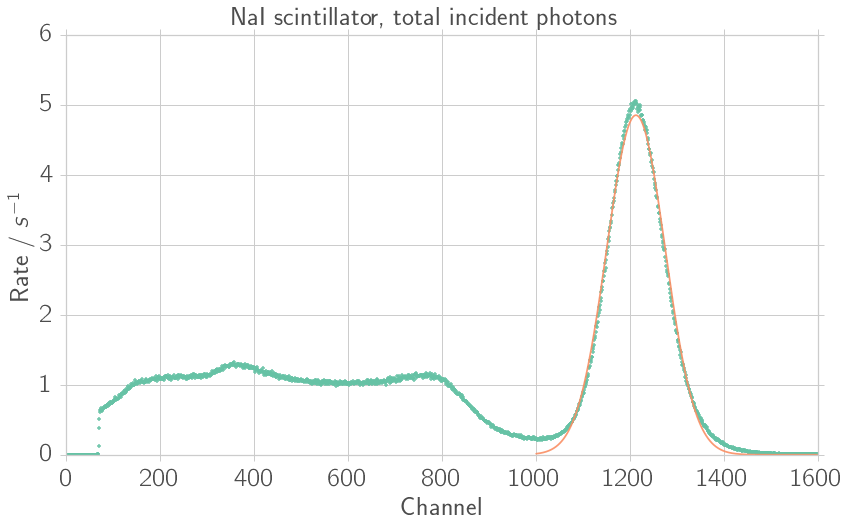

In [139]:
I_max = plot_total()

In [141]:
theta_na = [15, 30, 45, 60, 75, 90, 105]
amplitude = []
for theta in theta_na:
    amplitude+= [uc.ufloat(0,0) + np.load(npy_dir + 'i_photon_' + str(theta) + '.npy')]
I = ucarray(amplitude)
na_cal = np.load(npy_dir + 'na_calibration.npy')

/usr/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


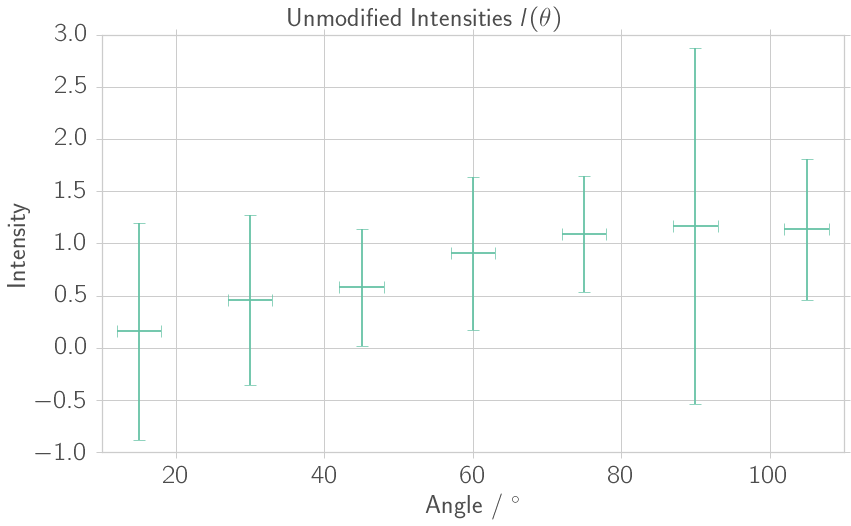

In [142]:
# Plotting
angle_error = 3
fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)
if not save_fig:
    fig1.suptitle("Unmodified Intensities $I(\\theta)$")
ax1.errorbar(theta_na, nom(I), yerr=sam(I),xerr = angle_error,\
             fmt=",", alpha=0.9,elinewidth=2.0, capsize=6.2, capthick=0.8)
ax1.set_xlabel("Angle / ^\circ")
ax1.set_ylabel("Intensity")
ax1.set_xlim(10,110)
ax1.grid(True)
if show_fig:
    fig1.show()
if save_fig:
    file_name = "na_intensities"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")


dE can be calculated with the scaling of the calibration => 1 Channel equals to a certain amount of energy. We furthermore have to bear in mind that we chose only every 16th bin in the distribution.

In [145]:
epsilon = un.uarray([0.41,0.45,0.51,0.55,0.63,0.65,0.70],[0.01]*7)
epsilon_0 = uc.ufloat(0.40,0.01)
mu = un.uarray([0.091,0.091,0.098,0.108,0.120,0.120,0.120],[0.001]*7)
mu_0 = uc.ufloat(0.089,0.001)
d = uc.ufloat(1.45,0.1)
n_e = 1.34E23 
u = uc.ufloat(4.756,0.1)
U = uc.ufloat(11.5,0.5)
D_omega = u**2  / U**2 * np.pi

In [149]:
cross_section = (I  / I_max)  * (epsilon_0 / epsilon) / (n_e * d * D_omega )/ \
(1 - un.exp(- (mu - mu_0) * d/2)) 

/usr/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


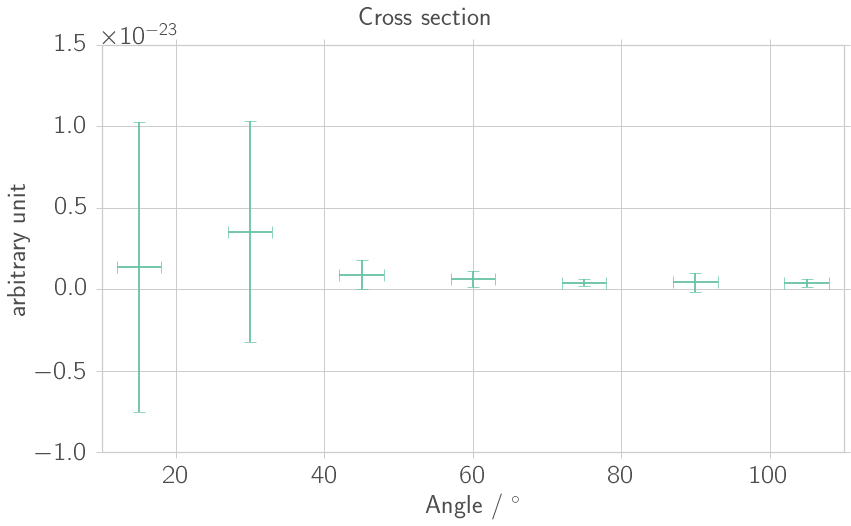

In [150]:
# Plotting
angle_error = 3
fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)
if not save_fig:
    fig1.suptitle("Cross section")
ax1.errorbar(theta_na, nom(cross_section), yerr=sam(cross_section),xerr = angle_error,\
             fmt=",", alpha=0.9,elinewidth=2.0, capsize=6.2, capthick=0.8)
ax1.set_xlabel("Angle / ^\circ")
ax1.set_ylabel("arbitrary unit")
ax1.set_xlim(10,110)
ax1.grid(True)
if show_fig:
    fig1.show()
if save_fig:
    file_name = "na_cross_section"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")

In [122]:
coeffs

757.9222097543479+/-2.8125346281028882

In [14]:
dE = na_cal[0] * 16
i_photon = dE * np.load(npy_dir + 'i_photon_' + str(theta) + '.npy')

"""
# Calculate integral directly
sums = []
theta = 75
y = np.load(npy_dir + 'na_rate_' + str(theta) + '.npy')
sums.append(np.sum(y))
na_cal = np.load(npy_dir + 'na_calibration.npy')
integral = np.array(sums) * dE
"""

# no_total_incident

'epsilon(energy)'
'mu(energy)'

NameError: name 'na_cal' is not defined

must further include: errors on counts for all measurements